# 为什么GPU加速是有意义的
在这个笔记本中，我们通过使用高斯模糊滤镜来展示GPU加速带来的速度提升。我们将使用[clEsperanto](https://github.com/clEsperanto/pyclesperanto_prototype/)库，它使用[OpenCL](https://www.khronos.org/opencl/)，并且兼容广泛的Intel、AMD和NVidia GPU。欢迎在您的GPU上运行它并测量加速效果！

另请参阅
* [clEsperanto基准测试笔记本](https://github.com/clEsperanto/pyclesperanto_prototype/#benchmarking)
* [cupy](https://cupy.dev/)
* [cucim](https://github.com/rapidsai/cucim)

**注意：** 基准测试结果会因图像大小、核大小、使用的操作、参数和使用的硬件而有很大差异。使用此笔记本来根据您的使用场景进行调整，并在您的目标硬件上进行基准测试。如果您有不同的场景或用例，非常欢迎您以拉取请求的形式提交您的笔记本！

In [1]:
import pyclesperanto_prototype as cle
from skimage import filters
import time

# to measure kernel execution duration properly, we need to set this flag. It will slow down exection of workflows a bit though
cle.set_wait_for_kernel_finish(True)

# selet a GPU with the following in the name. This will fallback to any other GPU if none with this name is found
cle.select_device('RTX')

<GeForce RTX 2080 Ti on Platform: NVIDIA CUDA (1 refs)>

In [2]:
# test data
import numpy as np

from skimage.io import imread
test_image = imread('Lund_000500_resampled-cropped.tif')

sigma = 10

In [3]:
# convolve with scikit-image
result_image = None

for i in range(0, 10):
    start_time = time.time()
    result_image = filters.gaussian(test_image, output=result_image, sigma=sigma)
    print("skimage Gaussian duration: " + str(time.time() - start_time))
    

skimage Gaussian duration: 0.644662618637085
skimage Gaussian duration: 0.63631272315979
skimage Gaussian duration: 0.6193966865539551
skimage Gaussian duration: 0.6499156951904297
skimage Gaussian duration: 0.6301307678222656
skimage Gaussian duration: 0.6531178951263428
skimage Gaussian duration: 0.6489198207855225
skimage Gaussian duration: 0.6308994293212891
skimage Gaussian duration: 0.7410404682159424
skimage Gaussian duration: 0.8148434162139893


In [4]:
# convolve with pyclesperanto
result_image_gpu = None

test_image_gpu = cle.push(test_image)

for i in range(0, 10):
    start_time = time.time()
    result_image_gpu = cle.gaussian_blur(test_image_gpu, result_image_gpu, sigma_x=sigma, sigma_y=sigma, sigma_z=sigma)
    print("pyclesperanto Gaussian duration: " + str(time.time() - start_time))

pyclesperanto Gaussian duration: 0.026170730590820312
pyclesperanto Gaussian duration: 0.002056121826171875
pyclesperanto Gaussian duration: 0.015659093856811523
pyclesperanto Gaussian duration: 0.019225597381591797
pyclesperanto Gaussian duration: 0.01566314697265625
pyclesperanto Gaussian duration: 0.015616178512573242
pyclesperanto Gaussian duration: 0.01566910743713379
pyclesperanto Gaussian duration: 0.015576839447021484
pyclesperanto Gaussian duration: 0.01562190055847168
pyclesperanto Gaussian duration: 0.023794889450073242


让我们检查一下结果是否看起来相似

In [5]:
import napari

viewer = napari.Viewer()
napari.run()

In [6]:
viewer.add_image(test_image)
viewer.add_image(result_image)
viewer.add_image(result_image_gpu)

<Image layer 'result_image_gpu' at 0x1d3b659c460>

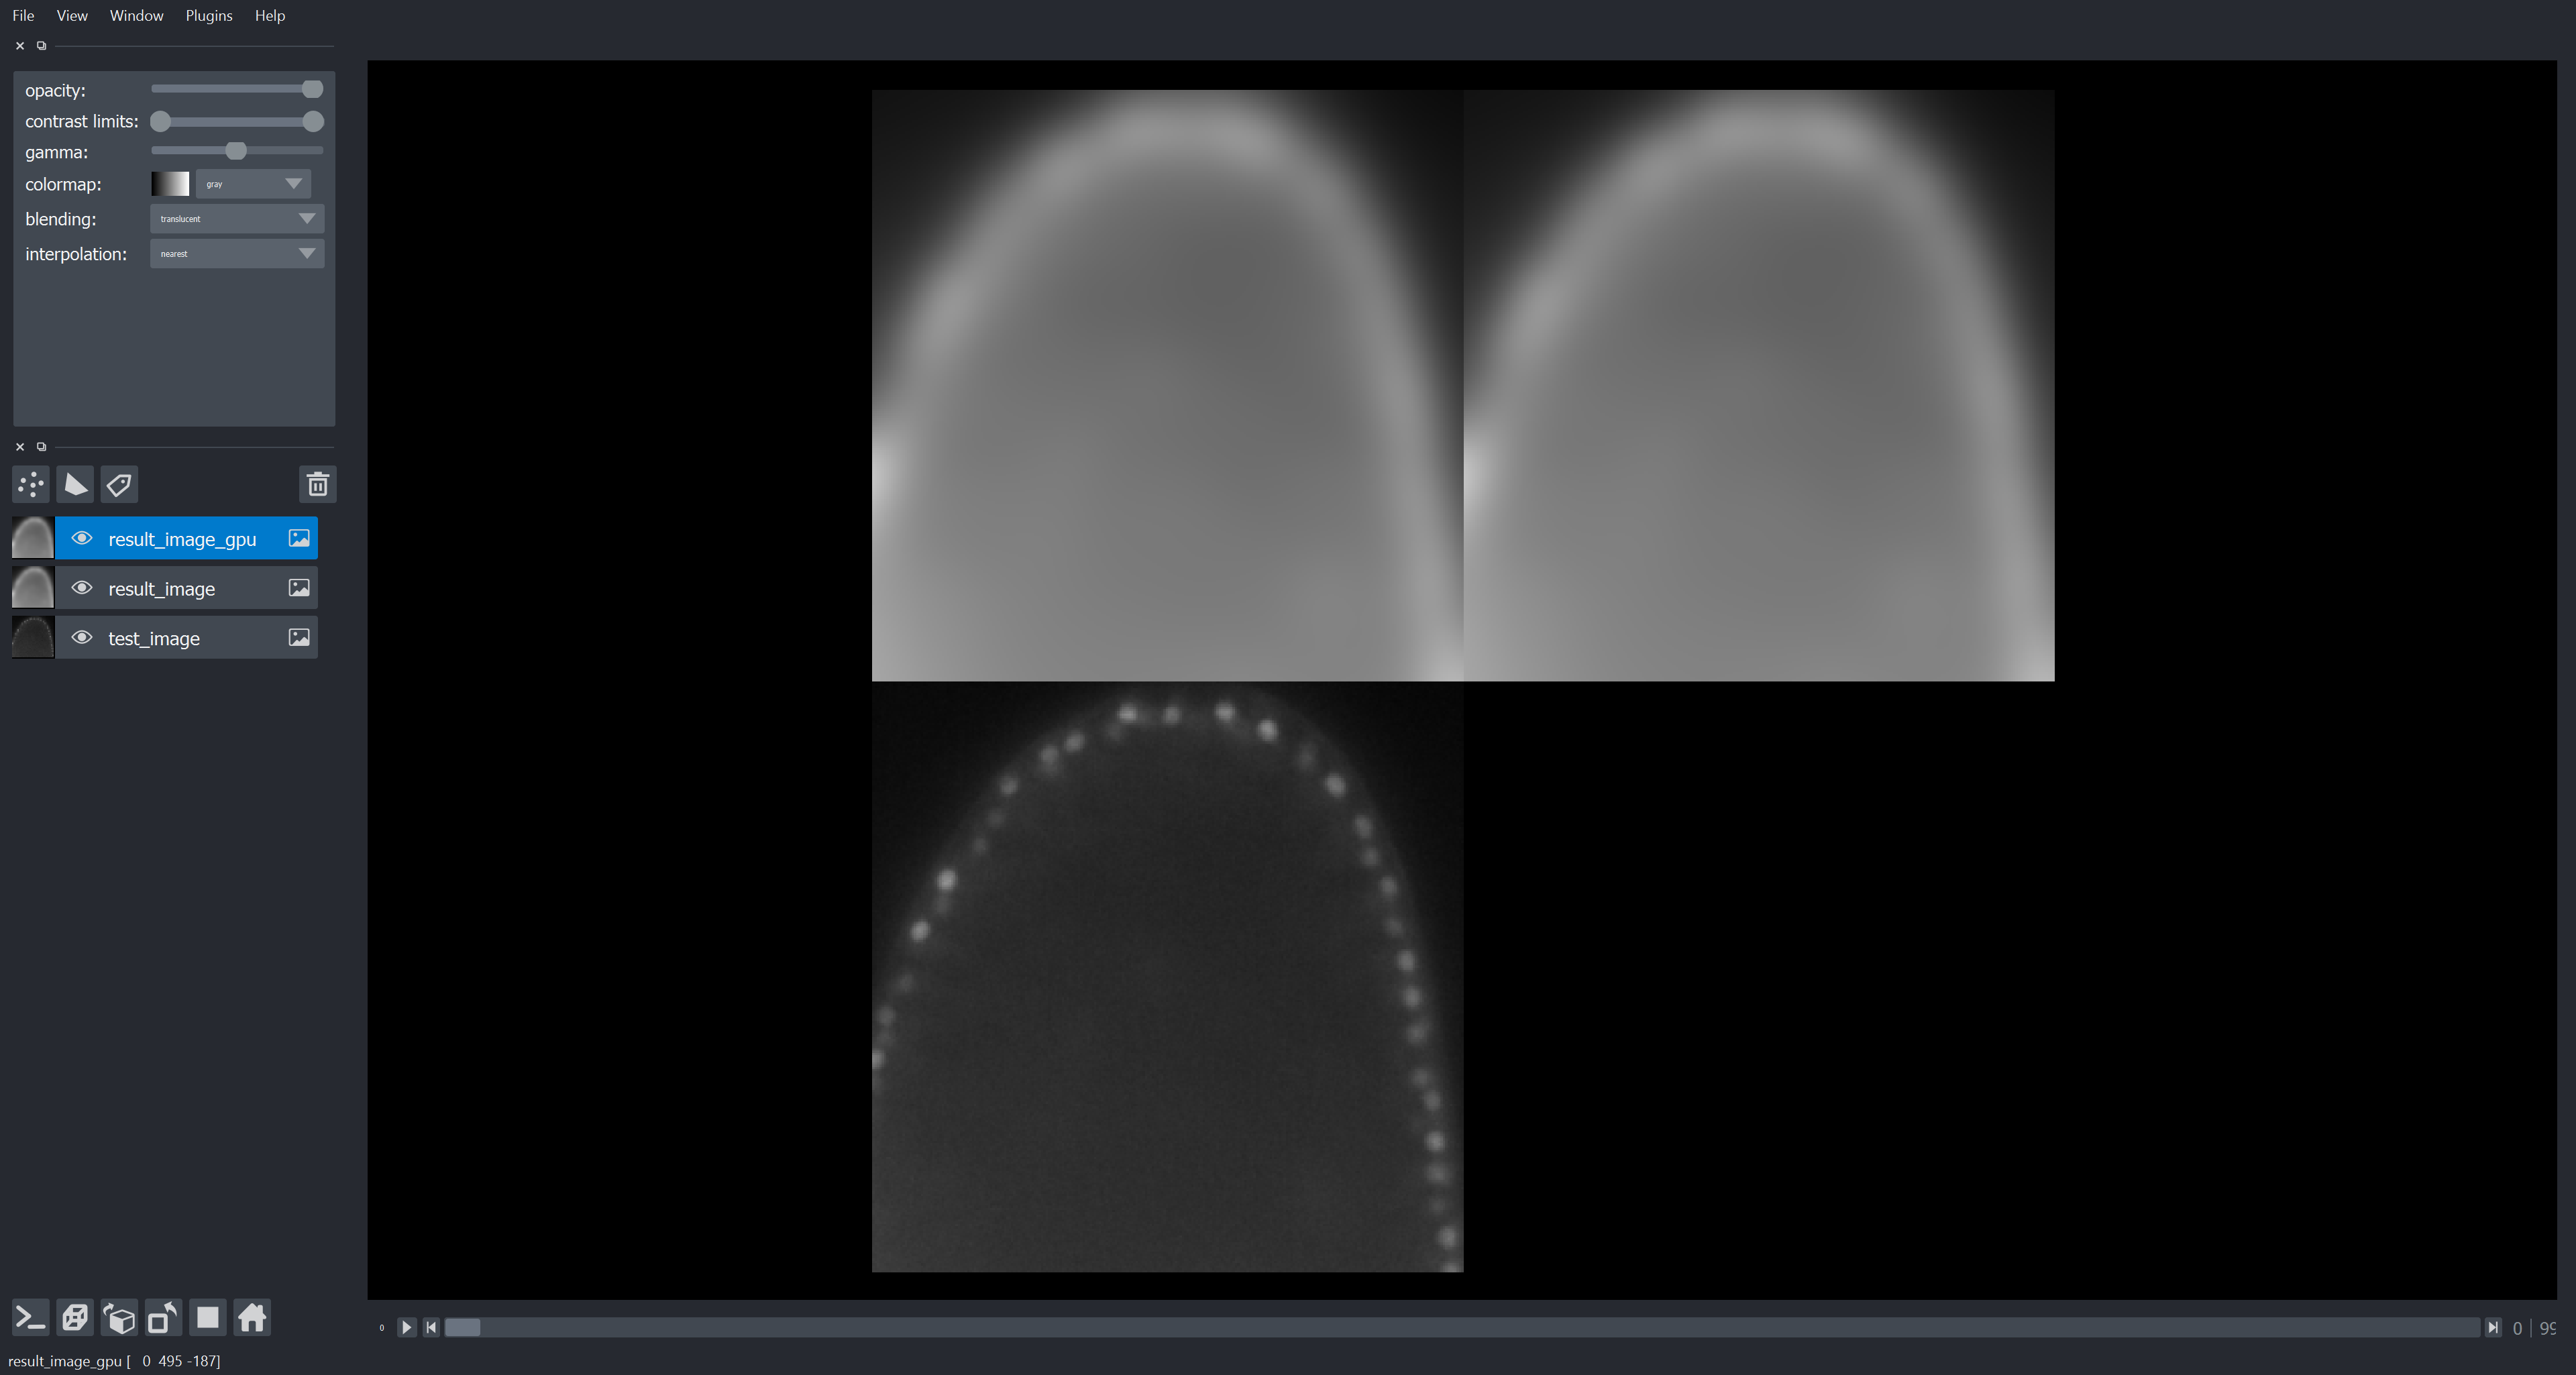

In [7]:
napari.utils.nbscreenshot(viewer)